In [1]:
import pandas as pd 
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import classification_report

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import signal

%matplotlib inline

In [2]:
pip install -U spacy

Requirement already up-to-date: spacy in c:\users\maria\anaconda3\lib\site-packages (3.2.2)
Note: you may need to restart the kernel to use updated packages.


# Data Selection and Preparation.


**So I am starting the process of data exploration by importing the data and observe their structure. Then I go on by checking their datatypes and see if I need to make some changes.**

In [3]:
proceedings = pd.read_csv('Greek_Parliament_Proceedings_1989_2019.csv',  
                  index_col=False 
                  )
print(proceedings.shape)
proceedings.head()

(1194407, 8)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...


In [4]:
proceedings.dtypes

member_name              object
sitting_date             object
parliamentary_period     object
parliamentary_session    object
parliamentary_sitting    object
political_party          object
speaker_info             object
speech                   object
dtype: object

**I see that the sitting date is not in a date format so I will change it and then I will deal with the missing values.**

In [5]:
proceedings.isna().sum()

member_name               47289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party             162
speaker_info             543871
speech                       10
dtype: int64

In [6]:
proceedings['sitting_date'] = pd.to_datetime(proceedings['sitting_date'].astype('str'), format='%Y-%m-%d')

proceedings.dtypes

member_name                      object
sitting_date             datetime64[ns]
parliamentary_period             object
parliamentary_session            object
parliamentary_sitting            object
political_party                  object
speaker_info                     object
speech                           object
dtype: object

**Continuing on, I have to make clearer the data that are about the parties and the speakers. I have a 227614 missing values for the speakers info and 69 for the political parties and since I cannot have information about them I am going to remove th missing values. Also, I am removing  the speech missing values because without the speech I cannot analyze further its content.**

In [7]:
proceedings.dropna(subset=['political_party','speech'], inplace=True)


proceedings.isna().sum()

member_name               47165
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party               0
speaker_info             543867
speech                        0
dtype: int64

In [8]:
print (proceedings.shape)

(1194235, 8)


In [9]:
proceedings['political_party'].value_counts()

νεα δημοκρατια                                                                     385634
πανελληνιο σοσιαλιστικο κινημα                                                     377680
συνασπισμος ριζοσπαστικης αριστερας                                                126572
κομμουνιστικο κομμα ελλαδας                                                         78631
βουλη                                                                               45876
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          35891
ανεξαρτητοι (εκτος κομματος)                                                        29951
λαικος ορθοδοξος συναγερμος                                                         23686
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     22991
λαικος συνδεσος - χρυση αυγη                                                        14172
ανεξαρτητοι ελληνες - πανος καμμενος                                                13785
ενωση κεντ

**From what I see here not all the values assigned to the political party variable are actually a political party such as  'βουλη', 'αντιπολιτευση' and  'ανεξαρτητοι(εκτος κομματος)'  which from their name only we understand that they do not belong to a political party. Αlsο, I am removing  'οικολογοι εναλλακτικοι'  because after a qucik search I saw that they are an organisation with political voice but not an actual political party and  'ανεξαρτητοι δημοκρατικοι βουλευτες'  because this was a group active only from 2013 to 2015 and including it does not help the analysis. Moreover, I am removing  'δημοκρατικη ανανεωση'  not only because I have very few data about it but it seized to exist in 1996 after 10 years of action and I am removing  'λαικη ενοτητα'  beacause of the few speeches but also beacause it is a relatively new political party which was founded in 2015. Last,I am removing  'κομμουνιστικο κομμα ελλαδας εσωτερικου'  because it seized to exist since 1987.**

In [10]:
proceedings = proceedings[~(proceedings['political_party'].isin(['βουλη', 'ανεξαρτητοι (εκτος κομματος)',
                                                                 'αντιπολιτευση',
                                                                 'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
                                                                'ανεξαρτητοι δημοκρατικοι βουλευτες',
                                                                'δημοκρατικη ανανεωση','λαικη ενοτητα',
                                                                'κομμουνιστικο κομμα ελλαδας εσωτερικου']))]

proceedings['political_party'].value_counts()

νεα δημοκρατια                                                                     385634
πανελληνιο σοσιαλιστικο κινημα                                                     377680
συνασπισμος ριζοσπαστικης αριστερας                                                126572
κομμουνιστικο κομμα ελλαδας                                                         78631
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          35891
λαικος ορθοδοξος συναγερμος                                                         23686
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     22991
λαικος συνδεσος - χρυση αυγη                                                        14172
ανεξαρτητοι ελληνες - πανος καμμενος                                                13785
ενωση κεντρωων                                                                       9888
το ποταμι                                                                            7672
δημοκρατικ

In [11]:
print (proceedings.shape)
proceedings.head()

(1115767, 8)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
5,κρητικος νικολαου παναγιωτης,1989-07-04,period 5,session 1,sitting 2,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Υπάρχει κανείς εκ των κυρίων συναδέλφων, ο οπ..."


Now that I have done some cleaning of the data, I see that the dataset is much smaller than the original one so I will not need to use a subset and I continue by exploring the other columns

In [12]:
proceedings['parliamentary_period'].value_counts()

period 17 presided parliamentary republic    169988
period 7                                     158819
period 11 presided parliamentary republic    134954
period 9 presided parliamentary republic     134181
period 10 presided parliamentary republic    128251
period 15 presided parliamentary republic    118857
period 13 presided parliamentary republic    115414
period 12 presided parliamentary republic     82317
period 8                                      37663
period 16 presided parliamentary republic     19872
period 5                                       9036
period 6                                       6389
period 14 presided parliamentary republic        26
Name: parliamentary_period, dtype: int64

In [13]:
proceedings['political_party'].value_counts()

νεα δημοκρατια                                                                     385634
πανελληνιο σοσιαλιστικο κινημα                                                     377680
συνασπισμος ριζοσπαστικης αριστερας                                                126572
κομμουνιστικο κομμα ελλαδας                                                         78631
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          35891
λαικος ορθοδοξος συναγερμος                                                         23686
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     22991
λαικος συνδεσος - χρυση αυγη                                                        14172
ανεξαρτητοι ελληνες - πανος καμμενος                                                13785
ενωση κεντρωων                                                                       9888
το ποταμι                                                                            7672
δημοκρατικ

In [14]:
proceedings['speaker_info'].value_counts()

προεδρευων                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
proceedings.loc[proceedings['speaker_info'] == 'προεδρος']

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
9,τσαλδαρης κωνσταντινου αθανασιος,1989-07-04,period 5,session 1,sitting 2,νεα δημοκρατια,προεδρος,"Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας ..."
11,τσαλδαρης κωνσταντινου αθανασιος,1989-07-04,period 5,session 1,sitting 2,νεα δημοκρατια,προεδρος,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
13,τσαλδαρης κωνσταντινου αθανασιος,1989-07-05,period 5,session 1,sitting 3,νεα δημοκρατια,προεδρος,"Μοιράζονται τώρα, κύριε Τσοβόλα. Παρακαλώ του..."
14,τσαλδαρης κωνσταντινου αθανασιος,1989-07-05,period 5,session 1,sitting 3,νεα δημοκρατια,προεδρος,Υπάρχει κανείς από τους κυρίους συναδέλφους π...
15,τσαλδαρης κωνσταντινου αθανασιος,1989-07-05,period 5,session 1,sitting 3,νεα δημοκρατια,προεδρος,"Κύριοι συνάδελφοι, κατά τη διεξαχθείσα μυστικ..."
...,...,...,...,...,...,...,...,...
1192968,βουτσης γεωργιου νικολαος,2019-02-13,period 17 presided parliamentary republic,session 4,sitting 75,συνασπισμος ριζοσπαστικης αριστερας,προεδρος,Όλοι θα μιλήσουν και θα τελειώσουμε και πιο ν...
1192970,βουτσης γεωργιου νικολαος,2019-02-13,period 17 presided parliamentary republic,session 4,sitting 75,συνασπισμος ριζοσπαστικης αριστερας,προεδρος,Θα το υπολογίσουν οι υπηρεσίες σε μισή με μία...
1193397,βουτσης γεωργιου νικολαος,2019-02-14,period 17 presided parliamentary republic,session 4,sitting 76,συνασπισμος ριζοσπαστικης αριστερας,προεδρος,"Κυρίες και κύριοι συνάδελφοι, επανερχόμεθα στ..."
1193398,βουτσης γεωργιου νικολαος,2019-02-14,period 17 presided parliamentary republic,session 4,sitting 76,συνασπισμος ριζοσπαστικης αριστερας,προεδρος,"Κυρίες και κύριοι συνάδελφοι, σύμφωνα με τον ..."


**After doing some research on the internet and looking through the 'προεδρευων' and 'προεδρος' speeches, I see that they do not talk for a political party in particular and they just introduce the talking subjects or the speakers in each instance and I cannot use them to identify data that I am interested in.**

In [16]:
proceedings = proceedings[~(proceedings['speaker_info'].isin(['προεδρευων', 'προεδρος']))]

proceedings['speaker_info'].value_counts()
print (proceedings.shape)

(708871, 8)


In [17]:
proceedings.political_party.unique()

array(['πανελληνιο σοσιαλιστικο κινημα', 'νεα δημοκρατια',
       'κομμουνιστικο κομμα ελλαδας',
       'συνασπισμος της αριστερας των κινηματων και της οικολογιας',
       'λαικος ορθοδοξος συναγερμος', 'πολιτικη ανοιξη',
       'δημοκρατικο κοινωνικο κινημα',
       'συνασπισμος ριζοσπαστικης αριστερας', 'δημοκρατικη αριστερα',
       'ανεξαρτητοι ελληνες - πανος καμμενος',
       'λαικος συνδεσος - χρυση αυγη', 'το ποταμι',
       'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
       'ενωση κεντρωων'], dtype=object)

In [18]:
proceedings.reset_index(inplace=True)

print (proceedings.shape)
proceedings.head(10)

(708871, 9)


,index,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,12,τσοβολας κωνσταντινου δημητριος,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ..."
1,16,τζαννετακης πετρου τζαννης,1989-07-05,period 5,session 1,sitting 3,νεα δημοκρατια,προεδρος της κυβερνησης και υπουργος των εξωτε...,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ..."
2,18,NaN,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,βουλευτης/ες,Να μας τη διαβάσετε.
3,21,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Κύριε Πρόεδρε, κατ' αρχή θα πω μερικές κουβέν..."
4,23,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,Λέει ο Κανονισμός ότι σε εξαιρετικές περιπτώσ...
5,25,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Όσον αφορά το πρώτο θέμα, κατ` αρχήν θέλω να π..."
6,27,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,Και εγώ δεν τις διάβασα.
7,29,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,Ούτε εγώ τις έχω διαβάσει. Ποια είναι η άποψή ...
8,31,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Με συγχωρείτε, αλλά για να το ξέρουν όλοι οι ..."
9,33,αλευρας νικολαου ιωαννης,1989-07-05,period 5,session 1,sitting 3,πανελληνιο σοσιαλιστικο κινημα,NaN,"Έπρεπε, όμως, εφόσον τις καταθέτετε..."


# Data Exploration

**The first thing I will try to explain and visualize is the speeches made per party. For that I will create a subset of the dataframe that will contain the differenet political parties and the speeches they have made in total.**

In [19]:
party_speeches = proceedings[['political_party','speech']]

print (party_speeches.shape)
party_speeches.head()

(708871, 2)


,political_party,speech
0,πανελληνιο σοσιαλιστικο κινημα,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ..."
1,νεα δημοκρατια,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ..."
2,πανελληνιο σοσιαλιστικο κινημα,Να μας τη διαβάσετε.
3,πανελληνιο σοσιαλιστικο κινημα,"Κύριε Πρόεδρε, κατ' αρχή θα πω μερικές κουβέν..."
4,πανελληνιο σοσιαλιστικο κινημα,Λέει ο Κανονισμός ότι σε εξαιρετικές περιπτώσ...


In [20]:
party_speeches = party_speeches.groupby('political_party',as_index=False).count() 


print (party_speeches.shape)
party_speeches.head()

(15, 2)


,political_party,speech
0,ανεξαρτητοι ελληνες - πανος καμμενος,5374
1,ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατ...,4243
2,δημοκρατικη αριστερα,4204
3,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,15402
4,δημοκρατικο κοινωνικο κινημα,6056


In [21]:
proceedings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708871 entries, 0 to 708870
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  708871 non-null  int64         
 1   member_name            707593 non-null  object        
 2   sitting_date           708871 non-null  datetime64[ns]
 3   parliamentary_period   708871 non-null  object        
 4   parliamentary_session  708871 non-null  object        
 5   parliamentary_sitting  708871 non-null  object        
 6   political_party        708871 non-null  object        
 7   speaker_info           189055 non-null  object        
 8   speech                 708871 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 48.7+ MB


<AxesSubplot:ylabel='political_party'>

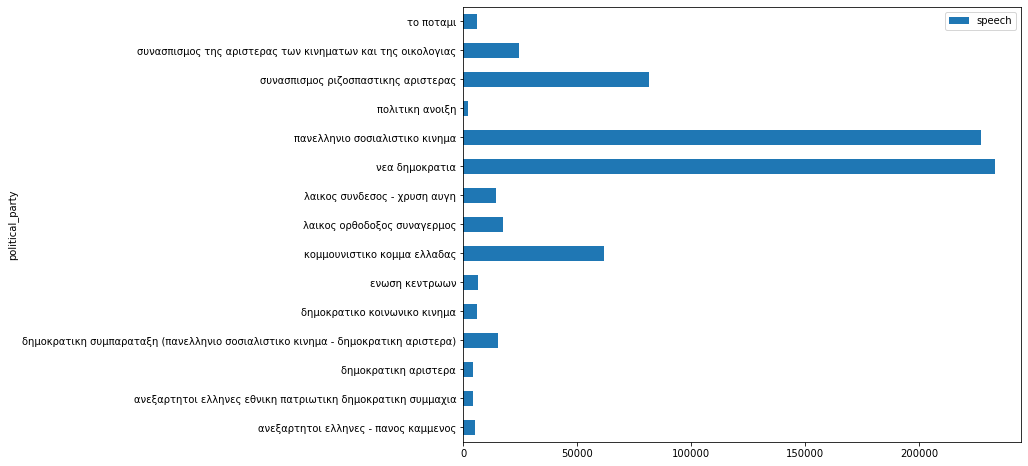

In [22]:
party_speeches.plot(x="political_party", y="speech", kind='barh', figsize=(10,8))

### Speeches Over Time

**I am asked to analyze the speeches made over time. I  should create a df with seperate month and year columns and then group by month and then by year with count to see how many speeches have been given per month and per year. Doing the same by date would not be fruitful because of the huge amount of data.**

In [23]:
speeches_overtime = proceedings[['political_party','speech', 'sitting_date']]

In [24]:
speeches_overtime ['month']= proceedings['sitting_date'].dt.month
speeches_overtime ['year']= proceedings['sitting_date'].dt.year

speeches_overtime.head()

<ipython-input-24-a38ec2a7ff7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-24-a38ec2a7ff7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,political_party,speech,sitting_date,month,year
0,πανελληνιο σοσιαλιστικο κινημα,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ...",1989-07-05,7,1989
1,νεα δημοκρατια,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ...",1989-07-05,7,1989
2,πανελληνιο σοσιαλιστικο κινημα,Να μας τη διαβάσετε.,1989-07-05,7,1989
3,πανελληνιο σοσιαλιστικο κινημα,"Κύριε Πρόεδρε, κατ' αρχή θα πω μερικές κουβέν...",1989-07-05,7,1989
4,πανελληνιο σοσιαλιστικο κινημα,Λέει ο Κανονισμός ότι σε εξαιρετικές περιπτώσ...,1989-07-05,7,1989


In [25]:
speeches_overyear = speeches_overtime[['speech','year']]

In [26]:
speeches_overyear = speeches_overyear.groupby('year',as_index=False).count() 

print (speeches_overyear.shape)
speeches_overyear.head()

(30, 2)


,year,speech
0,1989,6794
1,1990,23471
2,1991,30529
3,1992,34194
4,1993,28896


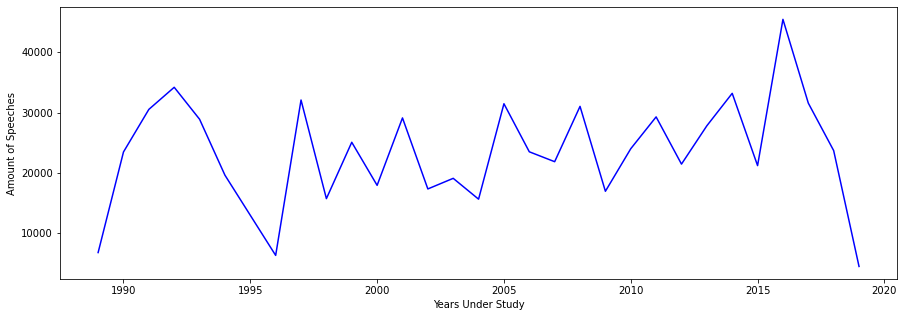

In [27]:
fig = plt.figure(figsize=(15,5))
plt.xlabel('Years Under Study')
plt.ylabel('Amount of Speeches')

plt.plot(speeches_overyear['year'], speeches_overyear['speech'], label='Speeches over the Years', color='blue')
    
plt.show()

**What I would normally look for in a plot that shows the amount of Speeches given throughout the years would be what could propably act as a cause for spiking parliament talks. The first thing I observe are the highest spikes on my plot which are in the years 1993-1997-2005-2008-2014-2016. The spiking in speeches in 1993 could be caused from the parliament elections that took place that year, although I could not see the same pattern for the other election years. What is more noticeable is that there is a spike in speeches one year previous to the election years.  That could be caused due to conflicts and debates happening critisizing the coverment at the time, heated arguments between the political parties about different approaches of the matters. Moreover, the spike in 2008 coould have been caused from the riots that happened in Athens which almost burnt down and where a teenager was shot to death by a police officer. Last, the biggest spike in my plot is happening during the years 2016 and 2017. These were the years after the election of 2015 that elected for the first time in the history of Greece a left party. The years that followed had a lot of changes and critisizing, conflicts between the parties, the economic crisis was at its peak.**

In [28]:
speeches_overmonth = speeches_overtime[['speech','month']]

In [29]:
speeches_overmonth = speeches_overmonth.groupby('month',as_index=False).count() 

print (speeches_overmonth.shape)
speeches_overmonth.head()

(12, 2)


,month,speech
0,1,62039
1,2,70138
2,3,63847
3,4,46206
4,5,61015


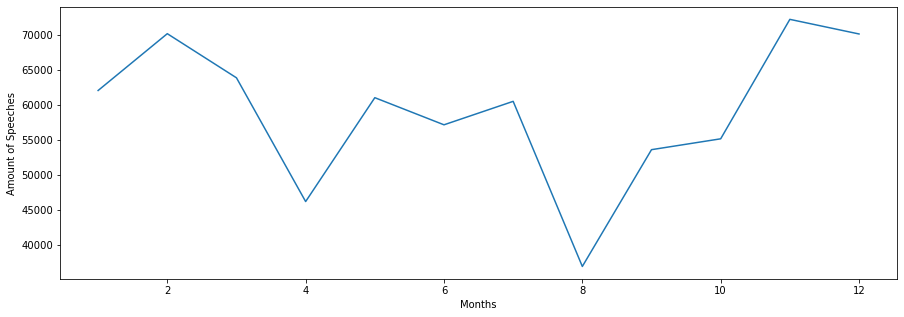

In [30]:
fig = plt.figure(figsize=(15,5))
plt.xlabel('Months')
plt.ylabel('Amount of Speeches')

plt.plot(speeches_overmonth['month'], speeches_overmonth['speech'], label='Speeches through Months')
    
plt.show()

**The data that show the speeches over the months show us that most speeches are happening during the fall and winter months. The highest peaks are in February and November and this could propably be happening because the goverment announces the plans for the year that started and also at the end maybe there is a retrospect at the end of it. Last, it is normal for August to have the least speeches since it is the main summer month and a lot of deprtments of the parliament close due to summer vacation.**

### Speeches per Political Party & Time 

In [31]:
speeches_party_year = speeches_overtime[['political_party','speech', 'year']]

In [32]:
speeches_party_year = speeches_party_year.groupby(['political_party', 'year'])['year'].count()

print (speeches_party_year.shape)
speeches_party_year.head()

(195,)


political_party                       year
ανεξαρτητοι ελληνες - πανος καμμενος  2009      72
                                      2010     531
                                      2011      83
                                      2012     870
                                      2013    1705
Name: year, dtype: int64

In [33]:
speeches_party_month = speeches_overtime[['political_party','speech', 'month']]

In [34]:
speeches_party_month = speeches_party_month.groupby(['political_party', 'month'])['month'].count()


print (speeches_party_month.shape)
speeches_party_month.head()

(180,)


political_party                       month
ανεξαρτητοι ελληνες - πανος καμμενος  1        553
                                      2        285
                                      3        436
                                      4        364
                                      5        565
Name: month, dtype: int64

### Speakers per Political Party 

In [35]:
speakers_party = proceedings[['political_party','member_name']]
speakers_party = speakers_party.drop_duplicates(subset=['member_name'])

In [36]:
speakers_party= speakers_party.groupby('political_party')['member_name'].count()

#speakers_party['political_party'] = speakers_party.index
#speakers_party['member_name'] = speakers_party.index

print (speakers_party.shape)
speakers_party.head()

(15,)


political_party
ανεξαρτητοι ελληνες - πανος καμμενος                                               14
ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια                          8
δημοκρατικη αριστερα                                                               12
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     2
δημοκρατικο κοινωνικο κινημα                                                        8
Name: member_name, dtype: int64

# Classification

**The goal in this part of the assignment is to create algorithms that can classify speeches with the target of political party.** 

In [37]:
dataframe = proceedings[['speech','political_party']]

dataframe.rename(columns={"political_party": "party"}, inplace=True)

dataframe.head()

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,speech,party
0,"Κύριε Πρόεδρε, δεν έχουν μοιραστεί όλα τα ψηφ...",πανελληνιο σοσιαλιστικο κινημα
1,"~""ΕΦΗΜΕΡΙΣ ΤΗΣ ΚΥΒΕΡΝΗΣΕΩΣ ΤΗΣ ΕΛΛΗΝΙΚΗΣ ΔΗΜΟ...",νεα δημοκρατια
2,Να μας τη διαβάσετε.,πανελληνιο σοσιαλιστικο κινημα
3,"Κύριε Πρόεδρε, κατ' αρχή θα πω μερικές κουβέν...",πανελληνιο σοσιαλιστικο κινημα
4,Λέει ο Κανονισμός ότι σε εξαιρετικές περιπτώσ...,πανελληνιο σοσιαλιστικο κινημα


In [38]:
speech= dataframe.speech
party= dataframe.party
party_names = sorted(dataframe.party.unique().tolist())

In [39]:
X_train, X_test, y_train, y_test = train_test_split(speech, party, test_size=0.25, random_state = 7)

In [40]:
import re

def preprocess_dataframe(dataframe):
    dataframe = dataframe.lower()
    dataframe = re.sub(r'\d+', '', dataframe)
    return dataframe

**In the following model we check every single word separately.**

In [41]:
uni_dataframeclf = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

uni_dataframeclf.fit(X_train, y_train)

predicted1 = uni_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted1 == y_test), end='\n')

print(classification_report(y_test, predicted1,
                                    target_names=party_names))

Score: 0.4293469060704895


C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.00      0.00      0.00      1327
                     ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια       0.00      0.00      0.00      1005
                                                           δημοκρατικη αριστερα       0.00      0.00      0.00      1007
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.00      0.00      0.00      3876
                                                   δημοκρατικο κοινωνικο κινημα       0.00      0.00      0.00      1463
                                                                 ενωση κεντρωων       0.00      0.00      0.00      1627
                                                    κομμουνιστικο κομμα ελλαδας       0.40      0.32      0.36     15596
                               

**Following I am going to check groups of words by two and by three to see how the score changes. This breaks down the words of the sentences in the text of speeches. For example in the sentence "This is a sentence", this will be broken down This is -is a -a sentence and by three words respectively.**

In [42]:
bi_dataframeclf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

bi_dataframeclf.fit(X_train, y_train)

predicted2 = bi_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted2 == y_test), end='\n')

print(classification_report(y_test, predicted2,
                                    target_names=party_names))

KeyboardInterrupt: 

In [ ]:
tri_dataframeclf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

tri_dataframeclf.fit(X_train, y_train)

predicted3 = tri_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted3 == y_test), end='\n')

print(classification_report(y_test, predicted3,
                                    target_names=party_names))

**The thrid model has slightly better score than the other two and when we use 3 the features increase massively and that is why it took a lot of computational time (more than two hours), the best choice at this point is to use the second best model which is the first one.**

**Moving forward I will run a dummy classifier to check the difference of accuracy from using simple rules to more complicated**

In [ ]:
from sklearn.dummy import DummyClassifier

uni_dummy = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DummyClassifier()),
                    ])

uni_dummy.fit(X_train, y_train)

predicted_1dummy = uni_dummy.predict(X_test)
print('Score:', np.mean(predicted_1dummy == y_test), end='\n')

print(classification_report(y_test, predicted_1dummy,
                                    target_names=party_names))

In [ ]:
from sklearn.dummy import DummyClassifier

bi_dummy = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DummyClassifier()),
                    ])

bi_dummy.fit(X_train, y_train)

predicted_2dummy =bi_dummy.predict(X_test)
print('Score:', np.mean(predicted_2dummy == y_test), end='\n')

print(classification_report(y_test, predicted_2dummy,
                                    target_names=party_names))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                    ])

logreg.fit(X_train, y_train)

predicted1 = logreg.predict(X_test)
print('Score:', np.mean(predicted1 == y_test), end='\n')

print(classification_report(y_test, predicted1,
                                    target_names=party_names))

**As it shows above, I used only the uni model because it was the best one.
Moving forward I am going to do a reevaluation of my data in terms of quantity of speeches and I am going to remove the parties that have under 10 thousand speeches and redo the above modelling to see if the scores will improve. By doing that I give my model the ability to distinguish better because I have less classes.**

In [ ]:
proceedings['political_party'].value_counts()

In [ ]:
proceedings_new = proceedings[~(proceedings['political_party'].isin(['ενωση κεντρωων', 'δημοκρατικο κοινωνικο κινημα',
                                                                 'το ποταμι',
                                                                 'ανεξαρτητοι ελληνες - πανος καμμενος',
                                                                'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
                                                                'δημοκρατικη αριστερα','πολιτικη ανοιξη']))]

proceedings['political_party'].value_counts()

In [ ]:
dataframe_new = proceedings_new[['speech','political_party']]

dataframe_new.rename(columns={"political_party": "party"}, inplace=True)

dataframe_new.head()

In [ ]:
speech= dataframe_new.speech
party= dataframe_new.party
party_names = sorted(dataframe_new.party.unique().tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(speech, party, test_size=0.25, random_state = 7)

In [ ]:
import re

def preprocess_dataframe(dataframe_new):
    dataframe_new = dataframe_new.lower()
    dataframe_new = re.sub(r'\d+', '', dataframe_new)
    return dataframe_new

In [ ]:
one_dataframeclf = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

one_dataframeclf.fit(X_train, y_train)

predicted1 = one_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted1 == y_test), end='\n')

print(classification_report(y_test, predicted1,
                                    target_names=party_names))

In [ ]:
two_dataframeclf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

two_dataframeclf.fit(X_train, y_train)

predicted2 = two_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted2 == y_test), end='\n')

print(classification_report(y_test, predicted2,
                                    target_names=party_names))

In [ ]:
three_dataframeclf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

three_dataframeclf.fit(X_train, y_train)

predicted3 = three_dataframeclf.predict(X_test)
print('Score:', np.mean(predicted3 == y_test), end='\n')

print(classification_report(y_test, predicted3,
                                    target_names=party_names))

In [ ]:
from sklearn.linear_model import LogisticRegression

one_logreg = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                    ])

one_logreg.fit(X_train, y_train)

predicted1 = one_logreg.predict(X_test)
print('Score:', np.mean(predicted1 == y_test), end='\n')

print(classification_report(y_test, predicted1,
                                    target_names=party_names))

In [ ]:
two_logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                    ])

two_logreg.fit(X_train, y_train)

predicted2 = two_logreg.predict(X_test)
print('Score:', np.mean(predicted2 == y_test), end='\n')

print(classification_report(y_test, predicted2,
                                    target_names=party_names))

**After downsizing the data to partys that have more speeches, I observed that my models' scores were rising. I also did logistic regression to the new dataframe but at the point where I reached the second model, there was a memory error and I could not perform it. Nevertheless, I am feeling confident with the first model where I could perform logistic regression because before the data downsizing it had a slightly better score than the second one.**

In [ ]:
from sklearn.dummy import DummyClassifier

one_dummy = Pipeline([('vect', CountVectorizer(preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DummyClassifier()),
                    ])

one_dummy.fit(X_train, y_train)

predicted_1dummy = one_dummy.predict(X_test)
print('Score:', np.mean(predicted_1dummy == y_test), end='\n')

print(classification_report(y_test, predicted_1dummy,
                                    target_names=party_names))

In [ ]:
from sklearn.dummy import DummyClassifier

two_dummy = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2),preprocessor=preprocess_dataframe)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DummyClassifier()),
                    ])

two_dummy.fit(X_train, y_train)

predicted_2dummy =two_dummy.predict(X_test)
print('Score:', np.mean(predicted_2dummy == y_test), end='\n')

print(classification_report(y_test, predicted_2dummy,
                                    target_names=party_names))

**Seeing that the dummy classifier gave accuray of 26% which is almost halph from the 50% accuracy we managed from our best model (one_logreg) shows that I am in a good path and doing a good job.**

### Grid search logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

gridlog = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())])

parameters = {
  'clf__C': (0.001,1,1000)
  
}

gs_one_logreg = GridSearchCV(gridlog, parameters, n_jobs=-1)

gs_one_logreg.fit(X_train, y_train)

best_parameters = gs_one_logreg.best_estimator_.get_params()
print('Best parameters:')
for param_name in parameters.keys():
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

**Now I have completed the hyperparameter tuning in logistic regression. I had changed the max iter in previous tries but it would not work due to memory limit.**

In [ ]:
from sklearn.model_selection import GridSearchCV


gridmult = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

parameters = {
  'clf__alpha': (0,1,2,3,4,5)
  'vec__max_df': (0.5,0.75,1)
  'vec__min_df': (1,5,10,20,50) 
 
}

gs_gridmult = GridSearchCV(gridmult, parameters, n_jobs=-1)

gs_gridmult.fit(X_train, y_train)

best_parameters = gridmult.best_estimator_.get_params()
print('Best parameters:')
for param_name in parameters.keys():
    print("\t%s: %r" % (param_name, best_parameters[param_name]))